# CASA Summary
The pipeline used for calibration and flagging closely follows that of the CASA pipeline (https://casaguides.nrao.edu/index.php?title=VLA-S-CASA_Pipeline-CASA6.2.1#Stage_7._hifv_checkflag:_Flag_possible_RFI_on_BP_calibrator_using_rflag). This notebook summarises the output of the pipeline (calibration tables, flagging summaries, data plots) and can be used to get an overview of the data and identify bad data that needs to be flagged manually.

In [1]:
import os
import sys
import h5py
import yaml
import casatasks
import numpy as np
from astropy.time import Time
import astropy.units as u
from ipywidgets import interact

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib as mpl

cmap = mpl.cm.viridis  
cmap.set_bad(color='red')

from IPython.display import Image

# read yaml file
with open("../../input/config.yaml", "r") as file:
    conf = yaml.safe_load(file)
    
sys.path.append(os.path.join(os.curdir, "../../"))

from vlapy import vladata, inspect

## Obervation Information 
The data below is the output of CASA's listobs task and can be used to fill in the yaml file "obs.yaml", which contains all the parameters for the pipeline.

In [18]:
obs = conf["obs list"][11]
root = os.path.join(conf["root"], f"{obs}")
name = obs.split(".")[0]

print(obs)

ms = os.path.join(root, f"{obs}_hanning.ms")
vladata.listobs(ms)

19A-056.sb37065331.eb37257531.58740.82100236111
BeginTime
58740.82101851851 

EndTime
58740.975046296306 

IntegrationTime
13308.000001907349 

field_0
code :  NONE
direction :  {'m0': {'unit': 'rad', 'value': -2.7439275295795866}, 'm1': {'unit': 'rad', 'value': 0.5324852109}, 'refer': 'J2000', 'type': 'direction'}
name :  3C286


field_1
code :  NONE
direction :  {'m0': {'unit': 'rad', 'value': -2.6436723749795865}, 'm1': {'unit': 'rad', 'value': -0.0366673823}, 'refer': 'J2000', 'type': 'direction'}
name :  J1354-0206


field_10
code :  NONE
direction :  {'m0': {'unit': 'rad', 'value': -2.4912335232795866}, 'm1': {'unit': 'rad', 'value': -0.018827254500000005}, 'refer': 'J2000', 'type': 'direction'}
name :  QSO J1429-0104


field_11
code :  NONE
direction :  {'m0': {'unit': 'rad', 'value': -2.489987067279586}, 'm1': {'unit': 'rad', 'value': -0.0006176526000000001}, 'refer': 'J2000', 'type': 'direction'}
name :  QSO J1429-0002


field_12
code :  NONE
direction :  {'m0': {'unit': 'rad'

## Flux Calibrator Model
Print model flux densities and plot model amplitude vs. uv-distance. If the calibrator is not resolved, its amplitude should be constant across different uv-distances. If it is slightly resolved, the amplitude will decrease as a function of uv-distance.

In [3]:
setjy = np.load(root + "/output/setjy.npy", allow_pickle='TRUE').item()

print("model flux densities in Jy\n")

for spw in range(16):
    print("SPW {:2d}: I: {:.2f}, U: {:.2f}, V: {:.2f}, Q: {:.2f}".format(spw, *setjy["0"][str(spw)]["fluxd"]))

model flux densities in Jy

SPW  0: I: 17.64, U: 0.00, V: 0.00, Q: 0.00
SPW  1: I: 17.15, U: 0.00, V: 0.00, Q: 0.00
SPW  2: I: 16.70, U: 0.00, V: 0.00, Q: 0.00
SPW  3: I: 16.27, U: 0.00, V: 0.00, Q: 0.00
SPW  4: I: 15.86, U: 0.00, V: 0.00, Q: 0.00
SPW  5: I: 15.49, U: 0.00, V: 0.00, Q: 0.00
SPW  6: I: 15.13, U: 0.00, V: 0.00, Q: 0.00
SPW  7: I: 14.79, U: 0.00, V: 0.00, Q: 0.00
SPW  8: I: 14.47, U: 0.00, V: 0.00, Q: 0.00
SPW  9: I: 14.16, U: 0.00, V: 0.00, Q: 0.00
SPW 10: I: 13.87, U: 0.00, V: 0.00, Q: 0.00
SPW 11: I: 13.60, U: 0.00, V: 0.00, Q: 0.00
SPW 12: I: 13.34, U: 0.00, V: 0.00, Q: 0.00
SPW 13: I: 13.09, U: 0.00, V: 0.00, Q: 0.00
SPW 14: I: 12.85, U: 0.00, V: 0.00, Q: 0.00
SPW 15: I: 12.62, U: 0.00, V: 0.00, Q: 0.00


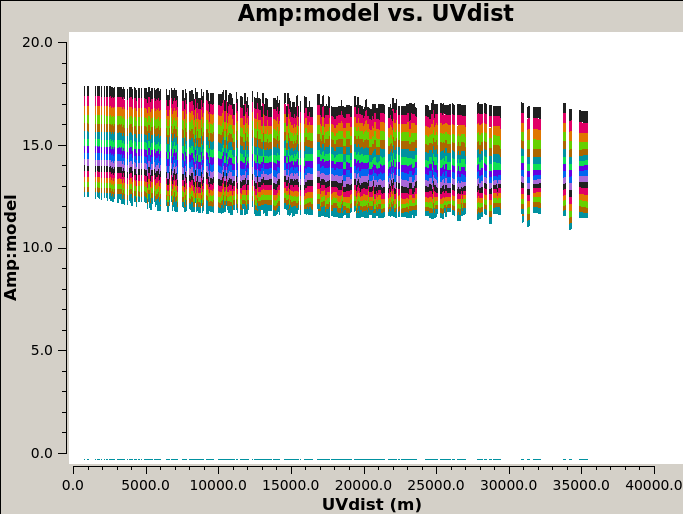

In [4]:
Image(filename=root + "/plots/calplots/setjy_model_amp_vs_uvdist.png")

## Prior Calibration

The prior calibration includes atmospheric opacity corrections, antenna offset corrections and requantizer (rq) gains. These are independent of calibrator observations and use external data instead.

### Weather
Plot weather data and print opacities. For frequencies below 10 GHz the opacity is negligibly small.  

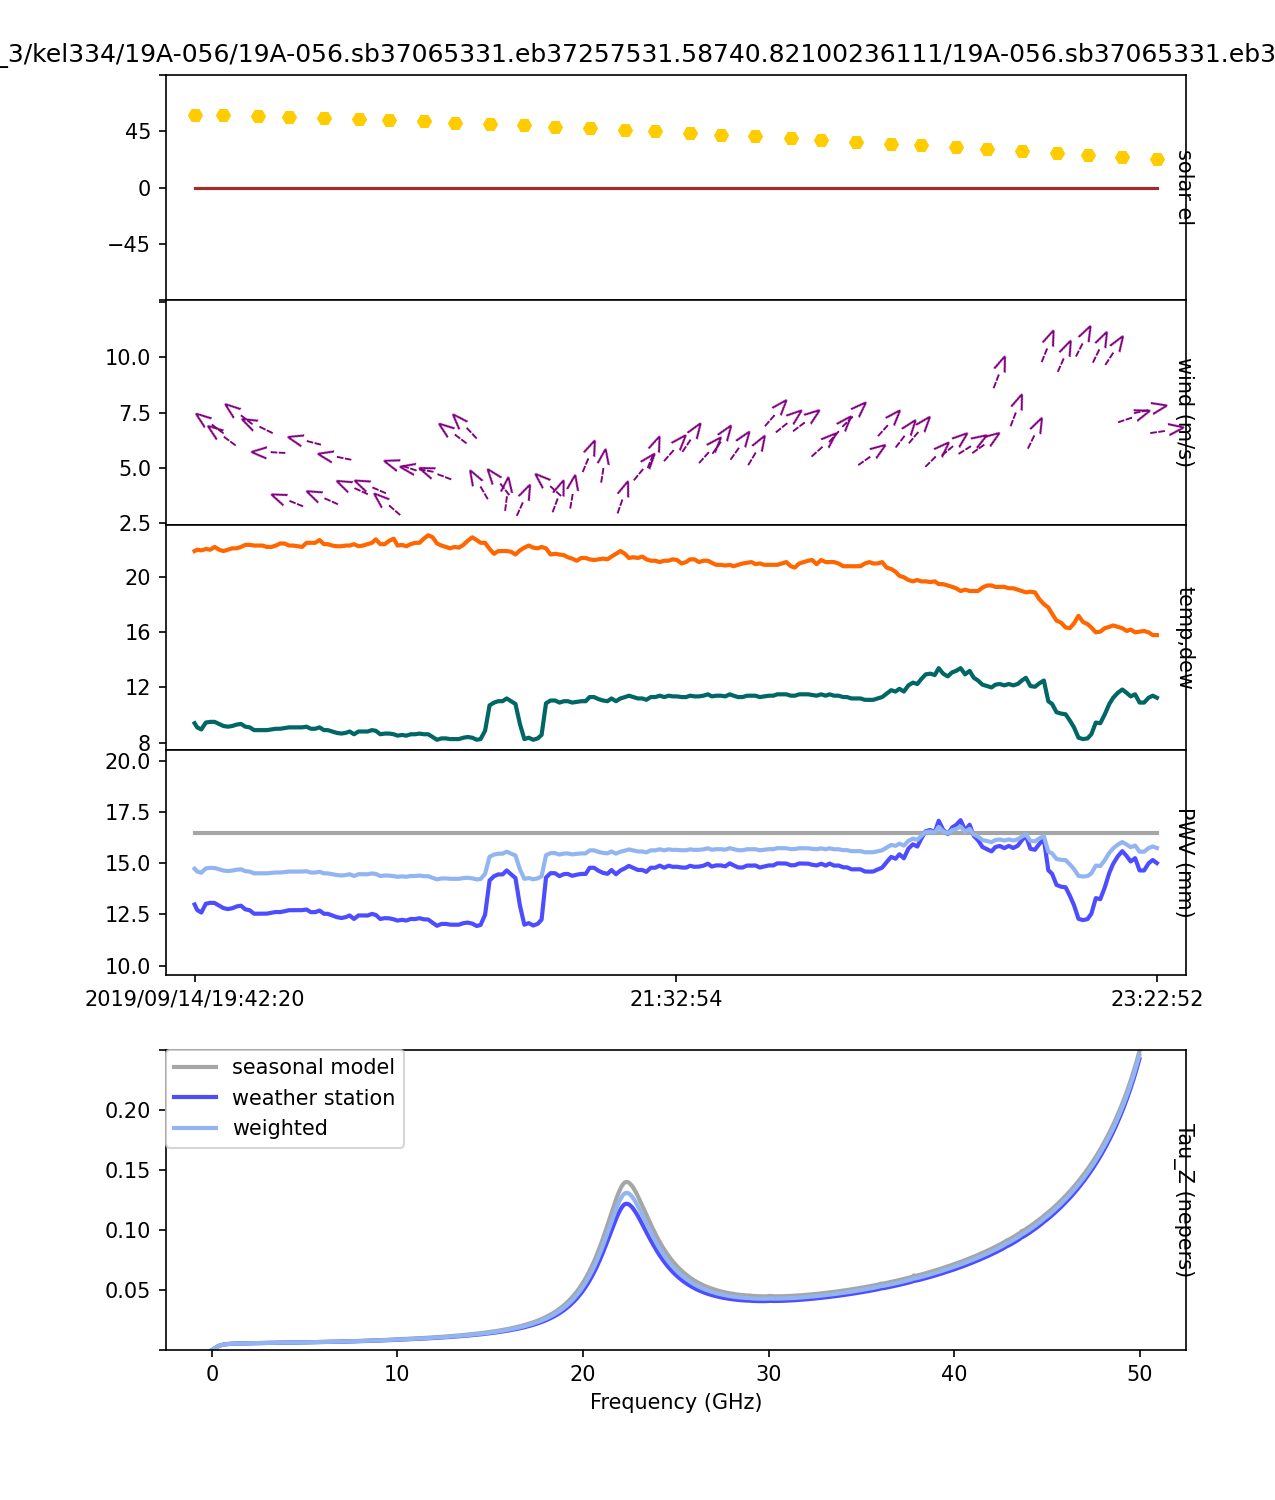

In [5]:
Image(filename=root + "/plots/calplots/weather.png")

In [6]:
opacities = np.load(root + "/output/weather.npy")

print("Opacities [Nepers]\n")

for spw, opacity in enumerate(opacities):
    print(f"SPW {spw}: {opacity}")

Opacities [Nepers]

SPW 0: 0.005155815809543294
SPW 1: 0.005215990532249339
SPW 2: 0.0052683882945999015
SPW 3: 0.005314233997701186
SPW 4: 0.005354965605922774
SPW 5: 0.005391180291516868
SPW 6: 0.005423809472361395
SPW 7: 0.005453327730110514
SPW 8: 0.005480264598487949
SPW 9: 0.005505027005488039
SPW 10: 0.005527905362113627
SPW 11: 0.005549246687356646
SPW 12: 0.005569199710150525
SPW 13: 0.005588043954782577
SPW 14: 0.0056058901631944194
SPW 15: 0.005622916908449433


## Plot Calibration Channels
These are the channels that have been selected for the gain calibration. They should be clean and should not exhibit any amplitude jumps.

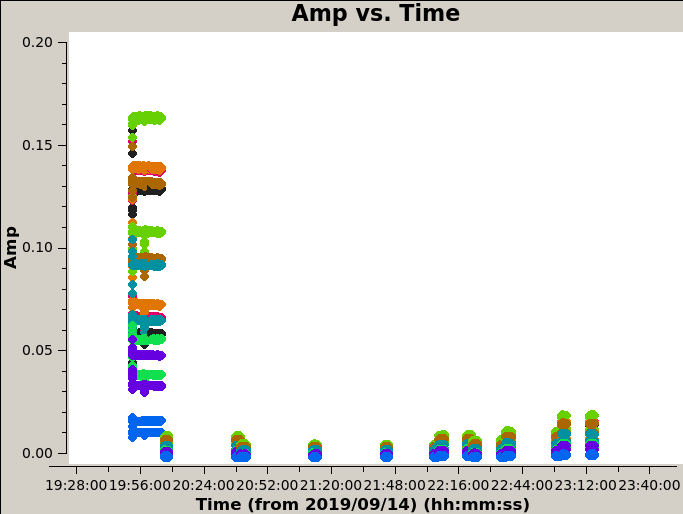

In [7]:
Image(filename=root + "/plots/dataplots/single_chans_amp_vs_time.png")

## Initial Calibration
The initial calibration is done to enable subsequent flagging with automated flagging routines such as CASA's RFlag. The calibration consists of an initial gain phase calibration, a delay calibration, an initial gain phase and amplitude calibration and a bandpass calibration. The two gain calibrations are used for the delay and bandpass calibrations, but are not applied to the data. The gain calibrations are done with a single channel per spectral window.

In [8]:
def plot_two_cols(im1, im2):
    """ 
    Plot two image side by side. E.g phase and amplitude.
    """
    fix, ax = plt.subplots(1, 2, figsize=(15, 5))

    if os.path.exists(im1):
        img_1 = mpimg.imread(im1)
        ax[0].imshow(img_1)

    if os.path.exists(im2):
        img_2 = mpimg.imread(im2)
        ax[1].imshow(img_2)

### Specify Gain Tables

In [9]:
# specify calibration table names
rnd = 0
delay_init_table = f"{name}.p.G{rnd}"
delay_table = f"{name}.K{rnd}"
bandpass_init_table = f"{name}.ap.G{rnd}"
bandpass_table = f"{name}.B{rnd}"

### Delay Initial Gain Calibration
This is an initial per-integration phase calibration and is done to avoid decorrelation under temporal averaging in the subsequent delay calibration. The gain phase should be stable in time. Antennas or spectral windows that have gain phase discontinuities should be flagged. If all but the reference antenna exhibit phase jumps, a difference reference antenna should be chosen.

In [10]:
def plot_delay_init_cal(ant):
    img = mpimg.imread(root + f"/plots/calplots/{delay_init_table}_ant_{ant}_Poln0,1.png")
    imgplot = plt.imshow(img)

interact(plot_delay_init_cal, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_delay_init_cal(ant)>

### Delay Calibration
The delay calibration is done by fitting for the phase slopes across frequency with respect to the reference antenna. The first and last 15 channels of the spectral windows are not used in this step, since they have lower gains. The delays should lie between -5 and 5 ns, and anything outside that range should be treated with suspicion.

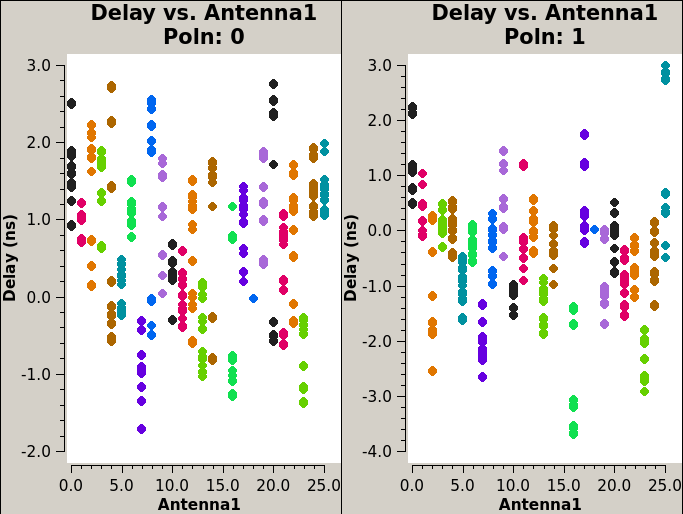

In [11]:
Image(filename=root + f"/plots/calplots/{delay_table}_Poln0,1.png")

### Bandpass Initial Gain Calibration
Similarly to above, we perform an initial gain calibration for the bandpass calibration, but this time we also solve for the amplitudes. The phases and amplitudes should be constant with time and discontinuous solutions should be flagged.

In [12]:
def plot_bandpass_init_cal(ant):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_init_table}_amp_ant_{ant}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_init_table}_phase_ant_{ant}_Poln0,1.png"
    )

interact(plot_bandpass_init_cal, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_bandpass_init_cal(ant)>

### Bandpass Calibration
The amplitudes and phases of the bandpass calibration should be close to 1 and zero respectively after the initial gain calibration. Discontinuities should be flagged.

In [13]:
def plot_bandpass_ant(ant):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_table}_amp_ant_{ant}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_table}_phase_ant_{ant}_Poln0,1.png"
    )
    
interact(plot_bandpass_ant, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_bandpass_ant(ant)>

Iterate through spectral windows and colorise by antenna. 

In [14]:
def plot_bandpass_spw(spw):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_table}_amp_spw_{spw}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_table}_phase_spw_{spw}_Poln0,1.png"
    )

interact(plot_bandpass_spw, spw=(0, conf["spw"]-1))

interactive(children=(IntSlider(value=7, description='spw', max=15), Output()), _dom_classes=('widget-interact…

<function __main__.plot_bandpass_spw(spw)>

### Plot Corrected Data
This data is averaged in time and colorised by antenna.

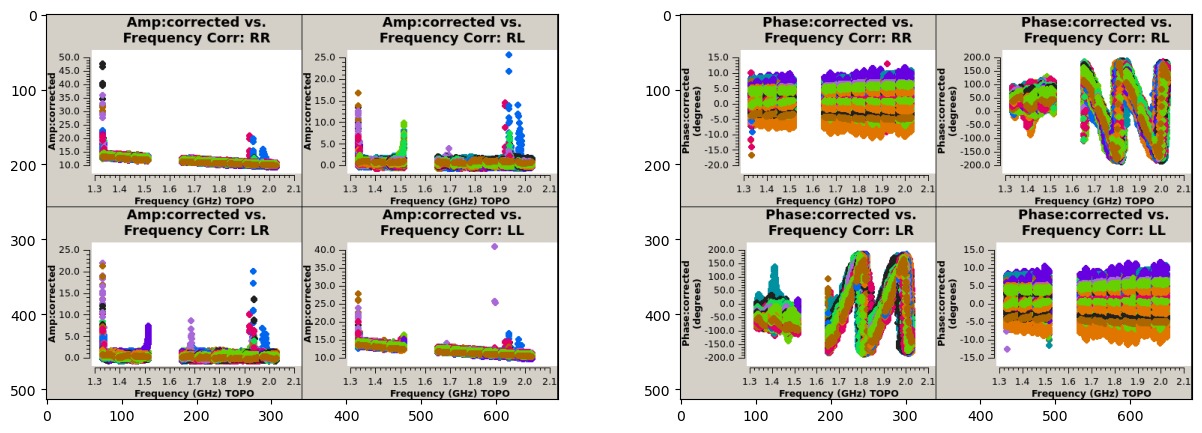

In [15]:
plot_two_cols(
    root + f"/plots/dataplots/fluxcal_initcal_round_0_amp_vs_freq_CorrRR,RL,LR,LL.png",
    root + f"/plots/dataplots/fluxcal_initcal_round_0_phase_vs_freq_CorrRR,RL,LR,LL.png"
)

#### Plot Averaged Corrected Data
Iterate through spectral windows to identify RFI and flag bad channels manually below.

In [16]:
def plot_corrected_spw(spw):
    img = mpimg.imread(root + f"/plots/dataplots/fluxcal_initcal_round_0_amp_vs_freq_avg_spw_{spw}_CorrRR,RL,LR,LL.png")
    plt.imshow(img)

interact(plot_corrected_spw, spw=(0, conf["spw"]-1))

interactive(children=(IntSlider(value=7, description='spw', max=15), Output()), _dom_classes=('widget-interact…

<function __main__.plot_corrected_spw(spw)>

### Flagging Summary
If no calibration solutions are available, data may be flagged (e.g. bad spectral windows).

In [17]:
rnd=0

# print flagging summary
def print_summary(item):
    for subitem in summary_before[item]:
        print(f"{item} {subitem}")
        print(
            "Before: {:.4f}, After: {:.4f}".format(
                100.0 * summary_before[item][subitem]["flagged"] / summary_before[item][subitem]["total"],
                100.0 * summary_after[item][subitem]["flagged"] / summary_after[item][subitem]["total"],
            )
        )
        print("")
        
summary_before = np.load(root + f"/output/initcal_round_{rnd}_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/initcal_round_{rnd}_flags_summary_after.npy", allow_pickle='TRUE').item()

print(f"Flag occupancy (percent) before and after initial calibration round {rnd}:\n")

print_summary("field")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after initial calibration round 0:

field 3C286
Before: 35.1772, After: 63.5457

antenna ea01
Before: 29.9448, After: 60.5947

antenna ea02
Before: 29.9580, After: 60.5947

antenna ea03
Before: 29.9470, After: 60.5947

antenna ea04
Before: 29.9511, After: 60.5947

antenna ea05
Before: 29.9448, After: 60.5947

antenna ea06
Before: 29.9580, After: 60.5947

antenna ea07
Before: 29.9470, After: 60.5947

antenna ea08
Before: 29.9511, After: 60.5947

antenna ea09
Before: 29.9448, After: 60.5947

antenna ea10
Before: 29.9580, After: 60.5947

antenna ea11
Before: 29.9470, After: 60.5947

antenna ea12
Before: 30.1202, After: 60.7321

antenna ea13
Before: 29.9448, After: 60.5947

antenna ea14
Before: 29.9580, After: 60.5947

antenna ea15
Before: 29.9470, After: 60.5947

antenna ea16
Before: 100.0000, After: 100.0000

antenna ea17
Before: 29.9448, After: 60.5947

antenna ea18
Before: 30.3229, After: 60.9596

antenna ea19
Before: 29.9470, After: 60.5947

antenna